In [39]:
# import autograd.numpy as np
import numpy as np
from pymanopt.manifolds import Stiefel, Sphere
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent, TrustRegions
from geomstats.geometry.hypersphere import Hypersphere
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import geomstats.backend as gs

# gs.random.seed(2020)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 9)

# Setting up the Hypersphere

In [40]:
# Sampling Hypersphere
n_samples=1000
dim = 2
sphere = Hypersphere(dim=dim)
points_in_manifold = sphere.random_uniform(n_samples)

In [41]:
# Creating Initial Point and Tangent Vector
x_0 = points_in_manifold[0,:]
vector = gs.array([1, 0, 1])
tangent_vector = sphere.to_tangent(vector, base_point=x_0)

print(f'Starting Point on manifold: {x_0}')
print(f'Tangent Vector: {tangent_vector}')

Starting Point on manifold: [ 0.12129116 -0.75254897 -0.64727003]
Tangent Vector: [ 1.06379659 -0.39582486  0.65954964]


In [42]:
# Wireframe for Sphere Surface
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)

#https://stackoverflow.com/questions/11140163/plotting-a-3d-cube-a-sphere-and-a-vector-in-matplotlib

Text(0.5, 0.92, 'Hypersphere of Dimension 3')

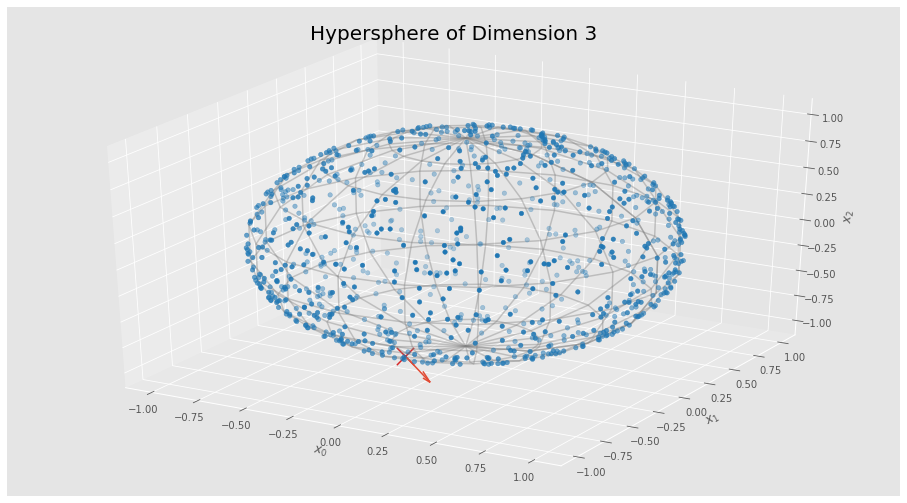

In [43]:
# Plotting Points in 3D
ax = plt.axes(projection='3d')

# Points with first one Highlighted
ax.scatter(points_in_manifold[1:,0],points_in_manifold[1:,1],points_in_manifold[1:,2],color="tab:blue",s=20)
ax.scatter(points_in_manifold[0,0],points_in_manifold[0,1],points_in_manifold[0,2],color="tab:red",s=300, marker="x")

# Tangent Vector
ax.quiver(points_in_manifold[0,0],points_in_manifold[0,1],points_in_manifold[0,2],
          points_in_manifold[0,0] + tangent_vector[0],points_in_manifold[0,1] + tangent_vector[1],points_in_manifold[0,2] + 
          tangent_vector[2], length=0.25)
# Sphere
ax.plot_wireframe(x, y, z, color="grey", alpha=0.4)
ax.set_xlabel(r'$x_0$')
ax.set_ylabel(r'$x_1$')
ax.set_zlabel(r'$x_2$')
ax.set_title(f'Hypersphere of Dimension {dim + 1}', fontsize=20)

In [1]:
def sphere_exp_map(v, x):
    """
    Input: v (tangent vector), x (starting point on manifold)
    Output: ... (point restrained to manifold)
    """
    r = 1 # assuming unit sphere
    ans = x * np.cos(np.linalg.norm(v)/r) + (r*v/np.linalg.norm(v))*np.sin(np.linalg.norm(v)/r)
    return ans

def sphere_R_map(v, x):`
    """
    Input: v (tangent vector), x (starting point on manifold)
    Output: ... (point restrained to manifold)
    """
    r = 1 # assuming unit sphere
    num = x + v
    denom = np.linalg.norm(x + v)
    return r * (num / denom)

# https://wiseodd.github.io/techblog/2019/02/22/optimization-riemannian-manifolds/

SyntaxError: invalid syntax (<ipython-input-1-dbd379ca3d00>, line 10)

In [45]:
# Testing Exponential Mapping
x_manifold = sphere_exp_map(tangent_vector, x_0)
x_manifold_geomstats = sphere.metric.exp(tangent_vector, base_point=x_0)

# https://geomstats.github.io/notebooks/02_from_vector_spaces_to_manifolds.html

In [46]:
print(f'Point from our Function: {x_manifold}\nPoint from GeomStats: {x_manifold_geomstats}')

Point from our Function: [ 0.81447275 -0.48357341  0.32061019]
Point from GeomStats: [ 0.81447275 -0.48357341  0.32061019]


In [47]:
# Testing Retraction Mapping
x_manifold_R = sphere_R_map(tangent_vector, x_0)
x_manifold_geomstats_R = sphere.metric.exp(tangent_vector, base_point=x_0)

In [48]:
x_manifold_R
# Not sure if geomstats has an option for retraction built in for sphere...

array([ 0.7181234 , -0.695876  ,  0.00744103])

# First Order Optimization Methods

## Riemanian Gradient Descent

In [49]:
def RGD(x, GradR, Retract, lam=1e-2, f=None, tolerance=1e-7, max_iter=1e4):
    """
    Implementation of Riemannian Gradient Descent Method (first order).

    Extended description of function.

    Parameters
    ----------
    x_0 : ndarray
        Input vector in R^n to initialize the model
    gradR : function handle
        Riemannian Gradient of cost function, f.
    Retract : function_handle
        Retraction or exponetial mapping back onto the manifold.
    f : function handle
        Cost function being optimized. If provided, then the model will use linesearch. 
    max_iter : int (default=10000)
        Maximum iterations for Trust-region model
    

    Returns
    -------
    x_arr : ndarray
        NumPy array consisting of every optimal value at each iterate
    error_arr : list
        List array consisting of every relative error (current iterate and previous iterate) based on l-2 norm

    """
    error_arr = []
    x_arr = x
    # print(x_arr)
    x_prev = x

    # if there is an objective function, perform backtracking line search 
    if f != None:
        for i in range(int(max_iter)):
        
            # First compute Riemannian gradient
            r_grad = GradR(x)

            # Perform linesearch
            lam = linesearch(x, f, GradRet, r_grad)

            # Calculate new iterate by moving along tangent space and then retracting back onto sphere
            x = Retract(-lam*r_grad, x)

            # Checking Error
            error = np.linalg.norm(x - x_prev)/np.linalg.norm(x)
            error_arr.append(error)
            x_arr = np.concatenate((x_arr, x), axis=1)

            # Stopping criteria
            if error < tolerance:
                return x_arr, error_arr
            x_prev = x
            
        print(f'Reached max iterations.')
        return x_arr, error_arr
    # Don't preform linesearch
    else:
        for i in range(int(max_iter)):
            
            # First compute Riemannian gradient
            r_grad = GradR(x)

            # Calculate new iterate by moving along tangent space and then retracting back onto sphere
            x = GradRet(-lam*r_grad, x)
            
            # Checking Error
            error = np.linalg.norm(x - x_prev)/np.linalg.norm(x)
            err.append(error)
            x_arr = np.concatenate((x_arr, x), axis=1)

            # stopping criteria
            if error < tolerance:
               return x_arr, error_arr
            x_prev = x
        
        print(f'Reached max iterations.')
        return x_arr, error_arr

def SphereRGrad(x, u):
    I = np.identity(len(x))
    return (I - x * x.T) @ u(x)

def linesearch(x, f, GradRet, r_grad):

    # constants for linesearch
    r = 1e-4
    tau = 0.8
    t = 0.5

    fx = f(x)
    i = 0
    # armijo condition (check when it starts increasing)
    while (fx - f(GradRet(-t * r_grad, x))) < (r * t * np.linalg.norm(r_grad)**2):
        t = tau * t
        i += 1
    return t

In [50]:
# Define hypershphere dimension and A matrix for cost function
dim = 10
# A = A.T @ A

# Costant Learning Rate and inital value
lam = 0.05

In [51]:
# Define cost function, euclidean gradient of cost, and riemannian gradient
f = lambda x: 0.5*x.T @ A @ x
df = lambda x: A @ x
gradR = lambda x: SphereRGrad(x, df)

A = np.random.rand(dim,dim)
A = 1/2*(A + A.T)

x_0 = np.random.rand(dim,1)
x_0 = x_0 / np.linalg.norm(x_0)

In [52]:
# Running RGD on variants
x_optimal, x_optimal_err = RGD(x_0, gradR, sphere_R_map, f=None, lam=lam)
x_optimal_ls, x_optimal_ls_err = RGD(x_0, gradR, sphere_R_map, f=f)
x_optimal_eucl, x_optimal_eucl_err = RGD(x_0, df, sphere_R_map, f=None, lam=lam)
x_optimal_eucl_ls, x_optimal_eucl_ls_err = RGD(x_0, df, sphere_R_map, f=f)

# # Results
print(f'Optimal Value is {x_optimal[:,-1]}\n achieved in {x_optimal.shape[1]} iterations.')
print(f'Optimal Value is {x_optimal_ls[:,-1]}\n achieved in {x_optimal_ls.shape[1]} iterations.')
print(f'Optimal Value is {x_optimal_eucl[:,-1]}\n achieved in {x_optimal_eucl.shape[1]} iterations.')
print(f'Optimal Value is {x_optimal_eucl_ls[:,-1]}\n achieved in {x_optimal_eucl_ls.shape[1]} iterations.')

Optimal Value is [-0.33709248  0.11356878  0.23290683  0.26298593 -0.65608297  0.08242596
 -0.42711518  0.22273159  0.02140867  0.28342482]
 achieved in 716 iterations.
Optimal Value is [-0.33709584  0.11356908  0.23290813  0.26298433 -0.656082    0.08242494
 -0.42711303  0.22273032  0.02140703  0.28342804]
 achieved in 155 iterations.
Optimal Value is [-0.33709231  0.11356876  0.23290676  0.26298601 -0.65608302  0.08242601
 -0.42711529  0.22273166  0.02140876  0.28342465]
 achieved in 744 iterations.
Optimal Value is [-0.33652158  0.11402828  0.23333455  0.26347497 -0.65582648  0.08287448
 -0.4268645   0.22320261  0.0218667   0.28354768]
 achieved in 76 iterations.


In [53]:
# Importing Packages
import cvxpy as cvx
import autograd.numpy as np
from pymanopt.manifolds import Stiefel, Sphere
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent
import time
import pandas as pd

In [54]:
# def results(x1, x2, x3, x4, x5, x5solver):
#     # x5 is PymanOpt
#     x1_v = x1[:,-1]
#     x2_v = x2[:,-1]
#     x3_v = x3[:,-1]
#     x4_v = x4[:,-1]

#     # Take the minimum since PyManOpt sometimes flips its sign?
#     x1_err = min(np.linalg.norm(x1_v - x5)/ np.linalg.norm(x5), np.linalg.norm(x1_v + x5)/ np.linalg.norm(-x5))
#     x2_err = min(np.linalg.norm(x2_v - x5)/ np.linalg.norm(x5), np.linalg.norm(x2_v + x5)/ np.linalg.norm(-x5))
#     x3_err = min(np.linalg.norm(x3_v - x5)/ np.linalg.norm(x5), np.linalg.norm(x3_v + x5)/ np.linalg.norm(-x5))
#     x4_err = min(np.linalg.norm(x4_v - x5)/ np.linalg.norm(x5), np.linalg.norm(x4_v + x5)/ np.linalg.norm(-x5))

#     return [[x1_err, x2_err, x3_err, x4_err], [x1.shape[1], x2.shape[1], x3.shape[1], x4.shape[1], x5solver._optlog['iterations']['iteration'][-1]]]

# # ========= Running Cross-Validation! =======

# # (1) Instantiate a manifold
# manifold = Sphere(dim)

# # (3) Instantiate a Pymanopt solver
# solver = SteepestDescent(maxiter=10000, mingradnorm=1e-7, logverbosity=2)

# # Results dictionary
# # # results = {, , , , }
# # x_optimal_arr = {}
# # x_optimal_ls_arr = {}
# # x_optimal_eucl_arr = {}
# # x_optimal_eucl_ls_arr = {}
# # Xopt_arr = {}

# # Master arrays for results
# x_optimal_arr = np.empty((1, 3))
# x_optimal_ls_arr = np.empty((1, 3))
# x_optimal_eucl_arr = np.empty((1, 3))
# x_optimal_eucl_ls_arr = np.empty((1, 3))
# Xopt_arr = np.empty((1, 3))

# num = 100
# for i in range(num):

#     # defining new A each time
#     print(f'Iteration {i}...\n')
#     A = np.random.rand(dim,dim)
#     A = 1/2*(A + A.T)

#     # New cost function, gradient, and riemannian gradient
#     f = lambda x: 0.5*x.T @ A @ x
#     df = lambda x: A @ x
#     gradR = lambda x: SphereRGrad(x, df)

#     # new random starting point each time
#     x_0 = np.random.rand(dim,1)
#     x_0 = x_0 / np.linalg.norm(x_0)

#     # Solving with models (timing each one!)
#     tic = time.clock()
#     x_optimal, x_optimal_err = RGD(x_0, gradR, sphere_R_map, f=None, lam=lam)
#     toc = time.clock()
#     t1 = toc - tic

#     tic = time.clock()
#     x_optimal_ls, x_optimal_ls_err = RGD(x_0, gradR, sphere_R_map, f=f)
#     toc = time.clock()
#     t2 = toc - tic

#     tic = time.clock()
#     x_optimal_eucl, x_optimal_eucl_err = RGD(x_0, df, sphere_R_map, f=None, lam=lam)
#     toc = time.clock()
#     t3 = toc - tic

#     tic = time.clock()
#     x_optimal_eucl_ls, x_optimal_eucl_ls_err = RGD(x_0, df, sphere_R_map, f=f)
#     toc = time.clock()
#     t4 = toc - tic
    
#     # ====== Solve with PyManOpt
#     # (2) Setup Problem
#     problem = Problem(manifold=manifold, cost=f)

#     # let Pymanopt do the rest
#     tic = time.clock()
#     Xopt = solver.solve(problem)
#     toc = time.clock()
#     Xopt = Xopt[0]
#     t5 = toc - tic

#     # Calculate norm values and iteration counts
#     x_results, iter_results = results(x_optimal, x_optimal_ls, x_optimal_eucl, x_optimal_eucl_ls, Xopt, solver)
    
#     # Create results array for each model iteration
#     x_optimal_res = np.array([x_results[0], iter_results[0], t1]).reshape(1,3)
#     x_optimal_ls_res = np.array([x_results[1], iter_results[1], t2]).reshape(1,3)
#     x_optimal_eucl_res = np.array([x_results[2], iter_results[2], t3]).reshape(1,3)
#     x_optimal_eucl_ls_res = np.array([x_results[3], iter_results[3], t4]).reshape(1,3)
#     x_optimal_Xopt_res = np.array([0, iter_results[4], t5]).reshape(1,3)

#     # Combining results into final array
#     x_optimal_arr = np.concatenate((x_optimal_arr, x_optimal_res), axis=0)
#     x_optimal_ls_arr = np.concatenate((x_optimal_ls_arr, x_optimal_ls_res), axis=0)
#     x_optimal_eucl_arr = np.concatenate((x_optimal_eucl_arr, x_optimal_eucl_res), axis=0)
#     x_optimal_eucl_ls_arr = np.concatenate((x_optimal_eucl_ls_arr, x_optimal_eucl_ls_res), axis=0)
#     Xopt_arr = np.concatenate((Xopt_arr, x_optimal_Xopt_res), axis=0)

# #  Skipping first since it just has empty values
# x_optimal_arr = x_optimal_arr[1:,:]
# x_optimal_ls_arr = x_optimal_ls_arr[1:,:]
# x_optimal_eucl_arr = x_optimal_eucl_arr[1:,:]
# x_optimal_eucl_ls_arr = x_optimal_eucl_ls_arr[1:,:]
# Xopt_arr = Xopt_arr[1:,:]

In [55]:
# # Computing Stats from Results (mean and starndard deviation)
# x_optimal_avg = np.mean(x_optimal_arr, axis = 0).reshape(1,3)
# x_optimal_std = np.std(x_optimal_arr, axis = 0).reshape(1,3)

# x_optimal_ls_avg = np.mean(x_optimal_ls_arr, axis = 0).reshape(1,3)
# x_optimal_ls_std = np.std(x_optimal_ls_arr, axis = 0).reshape(1,3)

# x_optimal_eucl_avg = np.mean(x_optimal_eucl_arr, axis = 0).reshape(1,3)
# x_optimal_eucl_std = np.std(x_optimal_eucl_arr, axis = 0).reshape(1,3)

# x_optimal_eucl_ls_avg = np.mean(x_optimal_eucl_ls_arr, axis = 0).reshape(1,3)
# x_optimal_eucl_ls_std = np.std(x_optimal_eucl_ls_arr, axis = 0).reshape(1,3)

# Xopt_avg = np.mean(Xopt_arr, axis = 0).reshape(1,3)
# Xopt_std = np.std(Xopt_arr, axis = 0).reshape(1,3)

# # Concatenate into final array for output
# results_table = np.concatenate((np.concatenate((x_optimal_avg, x_optimal_std), axis=1),
#                                 np.concatenate((x_optimal_ls_avg, x_optimal_ls_std), axis=1),
#                                 np.concatenate((x_optimal_eucl_avg, x_optimal_eucl_std), axis=1),
#                                 np.concatenate((x_optimal_eucl_ls_avg, x_optimal_eucl_ls_std), axis=1),
#                                 np.concatenate((Xopt_avg, Xopt_std), axis=1)), axis=0)
# # Round to 6 decimal places, convert to dataframe, and output latex format
# final_results = np.round(results_table, 6)
# final_results = pd.DataFrame(final_results)
# print(final_results.to_latex(index=False))

In [56]:
# Getting values from array cuz I was too lazy to figure out how to index properly with a lambda function
fx = []
fx_ls = []
fx_e = []
fx_e_ls = []

for i in range(x_optimal.shape[1]):
    fx.append(f(x_optimal[:,i]))
for i in range(x_optimal_ls.shape[1]):
    fx_ls.append(f(x_optimal_ls[:,i]))
for i in range(x_optimal_eucl.shape[1]):
    fx_e.append(f(x_optimal_eucl[:,i]))
for i in range(x_optimal_eucl_ls.shape[1]):
    fx_e_ls.append(f(x_optimal_eucl_ls[:,i]))

## Eigenvalue Checking for Specific Cost Function

In [57]:
# Eigenvalues, eigenvectors = ...
u, v = np.linalg.eigh(A)

In [58]:
# Min eigenvalue's index
idx = np.argmin(u)

print(f'Eigenvalues: {u}')
print(f'Minimum eigenvalue\'s eigenvector: {v[:,idx]}')
print(f' Optimal Objective Function value (2x) {f(x_optimal[:,-1])*2}') # corresponds to the minimum eigenvalue

Eigenvalues: [-0.92788949 -0.62050656 -0.32981578 -0.11923083 -0.00860771  0.11712896
  0.42067538  0.57747104  0.83397963  5.69506959]
Minimum eigenvalue's eigenvector: [-0.33709597  0.11356911  0.2329082   0.26298428 -0.65608195  0.08242491
 -0.42711293  0.22273028  0.02140698  0.28342818]
 Optimal Objective Function value (2x) -0.9278894861802764


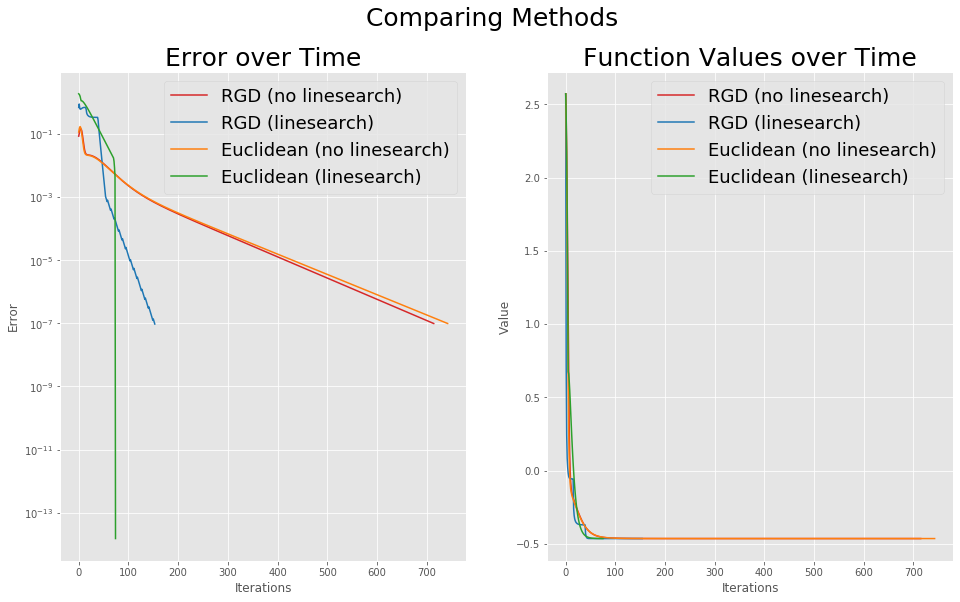

In [59]:
# Plotting
# ==== Error ===
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False)
fig.suptitle('Comparing Methods', fontsize=25)
ax1.plot(x_optimal_err, color='tab:red', label='RGD (no linesearch)')
ax1.plot(x_optimal_ls_err, color='tab:blue', label='RGD (linesearch)')
ax1.plot(x_optimal_eucl_err, color='tab:orange', label='Euclidean (no linesearch)')
ax1.plot(x_optimal_eucl_ls_err, color='tab:green', label='Euclidean (linesearch)')

# Features
ax1.set_title('Error over Time', fontsize=25)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Error')
ax1.set_yscale('log')
ax1.legend(fontsize=18)

# === Function Descent ===
ax2.plot(fx, color='tab:red', label='RGD (no linesearch)')
ax2.plot(fx_ls, color='tab:blue', label='RGD (linesearch)')
ax2.plot(fx_e, color='tab:orange', label='Euclidean (no linesearch)')
ax2.plot(fx_e_ls, color='tab:green', label='Euclidean (linesearch)')

# Features
ax2.set_title('Function Values over Time', fontsize=25)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Value')
ax2.legend(fontsize=18)

fig.savefig('comparing_methods.pdf')

## Comparing to PyManOpt

In [60]:
# Importing Packages
import autograd.numpy as np
from pymanopt.manifolds import Stiefel, Sphere
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent

In [61]:
# (1) Instantiate a manifold
manifold = Sphere(dim)

# (2) Setup Problem
problem = Problem(manifold=manifold, cost=f)

# (3) Instantiate a Pymanopt solver
solver = SteepestDescent(maxiter=10000, mingradnorm=1e-7, logverbosity=2)

# let Pymanopt do the rest
Xopt = solver.solve(problem)
print(dir(Xopt))

Compiling cost function...
Computing gradient of cost function...
 iter		   cost val	    grad. norm
    1	+4.4054971910558416e-01	2.08096459e+00
    2	+3.0975587975228591e-01	2.01727278e+00
    3	-5.5196899777146195e-02	8.59675725e-01
    4	-7.0802799151689189e-02	1.31599975e+00
    5	-1.2756059734193670e-01	1.08051212e+00
    6	-2.4276524344963205e-01	4.41076553e-01
    7	-3.1915230348153628e-01	9.45367082e-01
    8	-3.2614404799676860e-01	1.03556382e+00
    9	-3.5194916856964858e-01	8.76190410e-01
   10	-4.1362568720809195e-01	2.47803655e-01
   11	-4.1829331522337299e-01	6.52291781e-01
   12	-4.3437706106740170e-01	4.72488013e-01
   13	-4.4117972649649989e-01	4.17385373e-01
   14	-4.5508970821203165e-01	8.91087111e-02
   15	-4.6182316421567493e-01	1.19657217e-01
   16	-4.6270159126058003e-01	6.93179229e-02
   17	-4.6311233592870205e-01	2.67395919e-02
   18	-4.6328820747655608e-01	4.23779239e-02
   19	-4.6345287323975520e-01	2.06624128e-02
   20	-4.6350129438277049e-01	4.83647375e-02


In [62]:
print(f'PyManOpt: {Xopt[0]}')
print(f'Ours: {x_optimal[:, -1]}')
print(f'Relative error: {np.linalg.norm(x_optimal[:, -1] - Xopt[0]) / np.linalg.norm(Xopt[0])}')

PyManOpt: [-0.33709625  0.11356911  0.23290828  0.26298413 -0.65608189  0.0824248
 -0.42711278  0.22273015  0.02140683  0.28342842]
Ours: [-0.33709248  0.11356878  0.23290683  0.26298593 -0.65608297  0.08242596
 -0.42711518  0.22273159  0.02140867  0.28342482]
Relative error: 6.817465795865957e-06


# Second Order Optimization Methods

## Riemannian Newton's Method

In [73]:
def RNM(x_0, gradR, Retract, Hess, tolerance=1e-7, max_iter=1e4):
    """
    Implementation of Riemannian Newton Method (second order).

    Extended description of function.

    Parameters
    ----------
    x_0 : ndarray
        Input vector in R^n to initialize the model.
    gradR : function handle
        Riemannian Gradient of cost function, f.
    Retract : function_handle
        Retraction or exponetial mapping back onto the manifold.
    Hess : function handle
        Hessian-like linear operator or sufficiently positive-definite Hessian-like lineaer operator used to solve the sub-problem.
    tolerance : float (defaul=1e-7)
        Tolerance for stopping criteria. Compares previous iterate and current iterate difference in l-2 norm.
    max_iter : int (default=10000)
        Maximum iterations for Trust-region model.
    

    Returns
    -------
    x_arr : ndarray
        NumPy array consisting of every optimal value at each iterate.
    error_arr : list
        List array consisting of every relative error (current iterate and previous iterate) based on l-2 norm.

    """
    # Initiaize variables
    x = x_0
    x_prev = x
    error_arr = []
    x_arr = x

    # Iterate and find each newton step
    for i in range(int(max_iter)):

        # Find newton step by solving for s in H[s] = b
        s_k = np.linalg.inv(Hess(x)) @ - gradR(x)

        # Retract
        x = Retract(s_k, x)

        # Concatenating error
        error = np.linalg.norm(x - x_prev)/np.linalg.norm(x)
        error_arr.append(error)
        x_arr = np.concatenate((x_arr, x), axis=1)

        # Stopping criteria
        if error < tolerance: 
            return x_arr, error_arr
        x_prev = x

    print('Reached Max Iterations...')
    return x_arr, error_arr
def Hess_f(x):
    # Hessian for our specific cost function
    return A
def trust_region(x_0, f, gradR, Retract, H, radius, max_radius=3, threshold=1/10, max_iter=10000):

    """
    Implementation of Riemannian Trust-region (second order) optimization method.

    Extended description of function.

    Parameters
    ----------
    x_0 : ndarray
        Input vector in R^n to initialize the model.
    f : function handle
        Cost function being optimized.
    gradR : function handle
        Riemannian Gradient of cost function, f.
    Retract : function handle
        Retraction or exponetial mapping back onto the manifold.
    H : function handle
        Hessian-like linear operator or sufficiently positive-definite Hessian-like lineaer operator used to solve the sub-problem.
    radius : float
        Current radius of the Trust-region iterate .
    max_radius : float (default=3)
        Maximum radius allowed for the model, typically set to sqrt(dim(M)), where M is the Manifold.
    threshold : threshold (default=1/10)
        Threshold for accepting a Trust-region's candidate iterate.
    max_iter : int (default=10000)
        Maximum iterations for Trust-region model.
    

    Returns
    -------
    x_arr : ndarray
        NumPy array consisting of every optimal value at each iterate.
    error_arr : list
        List array consisting of every relative error (current iterate and previous iterate) based on l-2 norm.

    """

    # Initial values and defined model, m (evaluated at x_k with s being the variable we want to minimize)
    zero = np.zeros((x.shape[0],1))

    x = x_0
    x_arr = x
    x_prev = x
    error_arr = []

    # Qudratic approximation
    m = lambda x, v: f(x) +  gradR(x).T @ v + 0.5 * v.T @ H(x).T @ v

    for i in range(int(max_iter)):

        # Approximately solving sub-problem with truncated CG (v is our new s_k)
        b = -gradR(x)
        v, Hs = truncated_CG(H(x), b, radius)

        # Candidate iterate
        s = Retract(x, v)

        # Normalizer for numerical stability
        del_k = max(1, abs(f(x)))*1e-13

        # Quality quotient
        p_k = (f(x) - f(s) + del_k) / (- v.T @ gradR(x) - 0.5*v.T @ Hs + del_k)

        # Accept or reject
        if p_k > threshold:

            # Set new iterate
            x = s

            # Checking Error
            error = np.linalg.norm(x - x_prev)/np.linalg.norm(x)
            error_arr.append(error)
            x_arr = np.concatenate((x_arr, x), axis=1)
        else:
            
            # Checking Error
            error = np.linalg.norm(x - x_prev)/np.linalg.norm(x)
            error_arr.append(error)
            x_arr = np.concatenate((x_arr, x), axis=1)
        
        # Update trust-region radius
        if p_k < 0.25:
            radius = 0.25 * radius
        elif ((p_k > 0.75) & (np.linalg.norm(v) == radius)): # if point lies on radius then reduce radius
            radius = min(2*radius, max_radius)
        else:
            radius = radius
        
        # Stopping criteria
        if np.linalg.norm(gradR(x)) <= 1e-8 * np.linalg.norm(gradR(x_0)):
            return x_arr, error_arr
        x_prev = x
        
    return x_arr, error_arr

def truncated_CG(H, b, radius, K=1/10, theta=1):
    """
    Implementation of Conjugate Gradient

    Extended description of function.

    Parameters
    ----------
    H : function handle
        Hessian-like linear operator or sufficiently positive-definite Hessian-like lineaer operator used to solve the sub-problem.
    b : ndarray
        b = -grad(f(x)), where x is the current iterate of the Trust-region model.
    radius : float
        Current radius of the Trust-region iterate.
    K : float
        Stopping criteria parameter.
    theta : int
        Order of stopping criteria for convergence rate.

    Returns
    -------
    v : ndarray
        Solution to sub-problem for quadratic approximation.
    Hs : ndarray
        Left hand side of quadratic equation 'Hs=b,' where it can be used as a byproduct in the calculation of the quality quotient.

    """

    # Starting values
    v = np.zeros((b.shape[0],1))
    r_0 = p = b
    r = r_0
    max_iter = b.size # enough to cover whole span of s due to linear independence
    
    for i in range(max_iter):

        # Computing constants (turn Hessian into linear operator!)
        x = H @ p
        y = p.T @ x

        # finding coefficients of our basis, p
        a = np.linalg.norm(r)**2/y
        v_plus = v + a * p

        # Checking to see if H is not positive definite or we left the trust region
        if ((y <= 0) or (np.linalg.norm(v_plus) >= radius)):

            # Find t s.t. we minimize our model, m, and move away from v along p
            t = solve_t_quad(v, p, radius)

            # Update v
            v = v + t*p

            # Update byproduct, Hs
            Hs = b - r + t * x
            return v, Hs
        else:
            v = v_plus
        
        # updating residual
        r_prev = r
        r = r_prev - a * x

        # Stopping criteria - that is, if the residual is small, then we will have faster convergence
        if np.linalg.norm(r) <= np.linalg.norm(r_0) * min(np.linalg.norm(r_0)**(theta), K):
            Hs = b - r
            return v, Hs
        
        # updating B and H-conjugate directions, p
        B = np.linalg.norm(r)**2/(np.linalg.norm(r_prev)**2)
        p = r + B * p

def solve_t_quad(v, p, radius):
     """
    Solve for the root of the qudratic || v_{n-1} + t*p_{n-1}||^2_x - radius^2 = 0.

    The positive root corresponds to exactly the amount one should move back along p_{n-1} such that the iterate stays within the trust region.

    Parameters
    ----------
    v : ndarray
        Current iterate for an approximation of our newton step, s, in Hs = b.
    p : ndarray
        Current H-conjugate direction being utilized.
    radius : float
        Current radius of the Trust-region iterate.
    

    Returns
    -------
    t : float
        Positive root that solves for the quadratic framed in this problem.
    """

    # Quadratic constants
    a = np.linalg.norm(p)**2
    b = 2* v.T @ p
    c = np.linalg.norm(v)**2 - radius**2

    # Use quadratic formula and select only positive root (explained in ABG_{07}, section 3)
    t1 = (-b + np.sqrt(b**2 - 4 * a * c)) / (2*a)
    t2 = (-b - np.sqrt(b**2 - 4 * a * c)) / (2*a)

    # Posiive root
    t = max(t1, t2)

    return t

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 272)

In [64]:
f = lambda x: 0.5*x.T @ A @ x
df = lambda x: A @ x
gradR = lambda x: SphereRGrad(x, df)

A = np.random.rand(dim,dim)
A = A.T @ A

x_0 = np.random.rand(dim,1)
x_0 = x_0 / np.linalg.norm(x_0)

# Setting up trust region radii
max_rad = np.sqrt(x_0.shape[0])
radius = 1/8 * max_rad

# (3) Instantiate a Pymanopt solver
problem = Problem(manifold=manifold, cost=f)
solver2 = TrustRegions(maxiter=10000, mingradnorm=1e-7, logverbosity=2)

# Pymanopt
x_optimal_trust, x_optimal_trust_err = trust_region(x_0, f, gradR, sphere_R_map, Hess_f, radius, max_rad=max_rad)
Xopt_TR = solver2.solve(problem) # second order for comparison

Compiling cost function...
Computing gradient of cost function...
Computing Hessian of cost function...
Optimizing...
                                            f: +1.559761e+00   |grad|: 6.705437e+00
acc TR+   k:     1     num_inner:     0     f: +3.470806e-01   |grad|: 7.373805e-01   exceeded trust region
acc       k:     2     num_inner:     2     f: +2.139096e-01   |grad|: 5.862465e-01   negative curvature
acc       k:     3     num_inner:     2     f: +7.595070e-02   |grad|: 2.722853e-01   exceeded trust region
acc       k:     4     num_inner:     3     f: +3.904041e-02   |grad|: 1.251845e-01   negative curvature
acc       k:     5     num_inner:     3     f: +1.384285e-02   |grad|: 8.083002e-02   exceeded trust region
acc       k:     6     num_inner:     5     f: +4.049138e-03   |grad|: 3.701516e-02   exceeded trust region
acc       k:     7     num_inner:     8     f: +2.903564e-04   |grad|: 2.467998e-03   reached target residual-theta (superlinear)
acc       k:     8     num

In [65]:
print(f'Optimal Value is {x_optimal_trust[:,-1]}\n achieved in ... iterations.')
print(f'Relative error: {np.linalg.norm(x_optimal_trust[:,-1] - Xopt_TR[0]) / np.linalg.norm(Xopt_TR[0])}')

Optimal Value is [ 0.24635232 -0.07520114 -0.02312813  0.08493252  0.34105219  0.07662627
 -0.42023609  0.37160252  0.05545606 -0.69710582]
 achieved in ... iterations.
Relative error: 1.9999999999996596


In [66]:
# f = lambda x: 0.5*x.T @ A @ x
# df = lambda x: A @ x
# gradR = lambda x: SphereRGrad(x, df)

# A = np.random.rand(dim,dim)
# A = A.T @ A

# x_0 = np.random.rand(dim,1)
# x_0 = x_0 / np.linalg.norm(x_0)

# # (1) Instantiate a manifold
# manifold = Sphere(dim)

# # (2) Setup Problem
# problem = Problem(manifold=manifold, cost=f)

# # (3) Instantiate a Pymanopt solver
# solver1 = SteepestDescent(maxiter=10000, mingradnorm=1e-7, logverbosity=2)
# solver2 = TrustRegions(maxiter=10000, mingradnorm=1e-7, logverbosity=2)

# # let Pymanopt do the rest
# Xopt_RGD = solver1.solve(problem)
# Xopt_TR = solver2.solve(problem) # second order for comparison
# # print(Xopt_RGD[0])

# Running Riemannan Newton's Method
x_optimal_newton, x_optimal_newton_err = RNM(x_0, gradR, sphere_R_map, Hess_f)

In [67]:
# x_optimal_newton_arr = np.empty((1,3))
# Xopt_TR_arr = np.empty((1,3))
# x_optimal_trust_arr = np.empty((1,3))
# X = cvx.Variable((dim,1))

# for i in range(100):
#     A = np.random.rand(dim,dim)
#     A = A.T @ A

#     f = lambda x: 0.5*x.T @ A @ x
#     df = lambda x: A @ x
#     gradR = lambda x: SphereRGrad(x, df)

#     x_0 = np.random.rand(dim,1)
#     x_0 = x_0 / np.linalg.norm(x_0)

#     # (1) Instantiate a manifold
#     manifold = Sphere(dim)

#     # (2) Setup Problem
#     problem = Problem(manifold=manifold, cost=f)

#     # (3) Instantiate a Pymanopt solver
#     # solver1 = SteepestDescent(maxiter=10000, mingradnorm=1e-7, logverbosity=2)
#     solver2 = TrustRegions(maxiter=10000, mingradnorm=1e-7, logverbosity=2)

#     # Pymanopt
#     tic = time.clock()
#     Xopt_TR = solver2.solve(problem) # second order for comparison
#     toc = time.clock()
#     t2 = toc - tic

#     # Running Riemannan Newton's Method
#     tic = time.clock()
#     x_optimal_newton, x_optimal_newton_err = RNM(x_0, gradR, sphere_R_map, Hess_f)
#     toc = time.clock()
#     t1 = toc - tic

#     # Running Riemannan Newton's Method with Trust-region
#     tic = time.clock()
#     x_optimal_trust, x_optimal_trust_err = trust_region(x_0, f, gradR, sphere_R_map, Hess_f, radius, max_rad=max_rad)
#     toc = time.clock()
#     t3 = toc - tic

#     # cvx.py
#     # constraints = [cvx.norm(X) == 1]

#     # # Objective
#     # obj1 = cvx.Minimize((0.5)*cvx.quad_form(X, A))

#     # # setting the problems in cvxpy
#     # prob1 = cvx.Problem(obj1, constraints=constraints)

#     # # solving the problems
#     # prob1.solve(verbose=False)
#     Xopt_TR_iter = Xopt_TR[1]['final_values']['iterations']
#     x_optimal_newton_iter = x_optimal_newton.shape[1]
#     x_optimal_trust_iter = x_optimal_trust.shape[1]
#     # X.value

#     error_newton = min(np.linalg.norm(-Xopt_TR[0] + x_optimal_newton[:,-1])/np.linalg.norm(Xopt_TR[0]), np.linalg.norm(+Xopt_TR[0] +       x_optimal_newton[:,-1])/np.linalg.norm(-Xopt_TR[0]))
#     error_trust = min(np.linalg.norm(-Xopt_TR[0] + x_optimal_trust[:,-1])/np.linalg.norm(Xopt_TR[0]), np.linalg.norm(+Xopt_TR[0] +       x_optimal_trust[:,-1])/np.linalg.norm(-Xopt_TR[0]))

#     newton_res = np.array([error_newton, x_optimal_newton_iter, t1]).reshape(1,3)
#     trust_res = np.array([error_trust, x_optimal_trust_iter, t3]).reshape(1,3)
#     Xopt_TR_res = np.array([0, Xopt_TR_iter, t2]).reshape(1,3)

#     x_optimal_newton_arr = np.concatenate((x_optimal_newton_arr, newton_res), axis=0)
#     x_optimal_trust_arr = np.concatenate((x_optimal_trust_arr, trust_res), axis=0)
#     Xopt_TR_arr = np.concatenate((Xopt_TR_arr, Xopt_TR_res), axis=0)

# # x_optimal_ls, x_optimal_ls_err = RGD(x_0, gradR, sphere_R_map, f=f)

# x_optimal_newton_arr = x_optimal_newton_arr[1:,:]
# Xopt_TR_arr = Xopt_TR_arr[1:,:]
# x_optimal_trust_arr = x_optimal_trust_arr[1:,:]

In [68]:
# x_optimal_newton_avg = np.mean(x_optimal_newton_arr, axis=0).reshape(1,3)
# x_optimal_newton_std = np.std(x_optimal_newton_arr, axis=0).reshape(1,3)

# Xopt_TR_avg = np.mean(Xopt_TR_arr, axis=0).reshape(1,3)
# Xopt_TR_std = np.std(Xopt_TR_arr, axis=0).reshape(1,3)

# x_optimal_trust_avg = np.mean(x_optimal_trust_arr, axis=0).reshape(1,3)
# x_optimal_trust_std = np.std(x_optimal_trust_arr, axis=0).reshape(1,3)

In [69]:
fx_n = []
fx_r_tr = []
for i in range(x_optimal_newton.shape[1]):
    fx_n.append(f(x_optimal_newton[:,i]))
for i in range(x_optimal_trust.shape[1]):
    fx_r_tr.append(f(x_optimal_trust[:,i]))

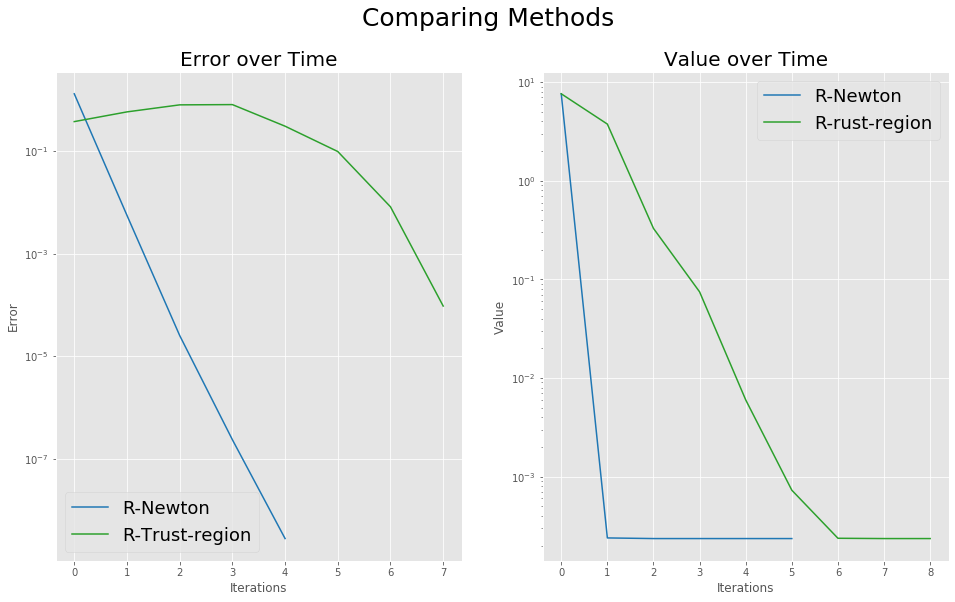

In [70]:
# Plotting local error over time
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Comparing Methods', fontsize=25)

# Error Over Time
ax1.plot(x_optimal_newton_err, color='tab:blue', label='R-Newton')
ax1.plot(x_optimal_trust_err, color='tab:green', label='R-Trust-region')

# Features
ax1.set_title('Error over Time', fontsize=20)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Error')
ax1.set_yscale('log')
ax1.legend(fontsize=18)

# Function Values
ax2.plot(fx_n, color='tab:blue', label='R-Newton')
ax2.plot(fx_r_tr, color='tab:green', label='R-rust-region')

# Features
ax2.set_title('Value over Time', fontsize=20)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Value')
ax2.set_yscale('log')
ax2.legend(fontsize=18)
fig.savefig('comparing_methods_second.pdf')